# Loading libraries and basic objects

In [ ]:
# !pip install --upgrade yasa
# !pip install fooof
# !pip install bycycle
# !pip install plotly

In [ ]:
# #Yasa
# import yasa
# import pandas as pd
# import seaborn as sns
# from mne.filter import filter_data
# sns.set(font_scale=1.2)
# # NeuroDSP
# import neurodsp as ndsp
# from neurodsp.spectral import compute_spectrum, rotate_powerlaw
# from neurodsp.utils import create_times
# from neurodsp.utils.download import load_ndsp_data
# from neurodsp.plts.spectral import plot_power_spectra
# from neurodsp.plts import plot_filter_properties, plot_time_series
# from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
# from neurodsp.filt.utils import compute_frequency_response, compute_transition_band
# from neurodsp.sim import sim_combined
# # FOOOF
# from fooof import FOOOF
# from fooof.sim.gen import gen_power_spectrum
# from fooof.sim.utils import set_random_seed
# from fooof.plts.spectra import plot_spectra
# from fooof.plts.annotate import plot_annotated_model
# # bycycle
# from bycycle import Bycycle
# from bycycle.features import compute_features
# from bycycle.cyclepoints import find_extrema, find_zerox
# from bycycle.cyclepoints.zerox import find_flank_zerox
# from bycycle.plts import plot_cyclepoints_array
# from bycycle.utils.download import load_bycycle_data
# # Other
# from scipy.io import loadmat
# import scipy.signal as signal
# import numpy as np
# import pandas as pd
# from scipy import signal
# from scipy.signal import savgol_filter
# from scipy.stats import zscore
# from scipy.signal import hilbert
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr
# from scipy.stats import mode
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# import plotly.graph_objs as go

# pd.options.display.max_columns = 10

In [ ]:
!pip install neurodsp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install emd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
import matplotlib.pyplot as plt
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Loading sleep scoring data from MAT files stored in Google Drive.
path_to_pt5 = '/content/drive/My Drive/Donders Internship/2018-07-26_14-20-46_Post-Trial5'

In [ ]:
# pfc_data = loadmat(path_to_pt5 + '/PFC_100_CH52_0.continuous.mat')
pfc_data = loadmat(path_to_pt5 + '/PFClfpCleaned.mat')
pfc_data = pfc_data['PFClfpCleaned']
pfc_data = pfc_data.flatten()

In [ ]:
pfc_data.shape

(10801835,)

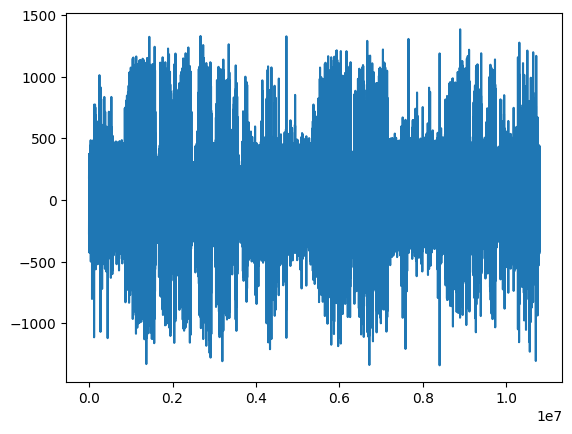

In [ ]:
plt.plot(pfc_data)

In [ ]:
sleep_scoring = loadmat(path_to_pt5 + '/2018-07-26_14-20-46_Post-Trial5-states.mat')
sleep_scoring = sleep_scoring['states']
sleep_scoring = sleep_scoring.flatten()

In [ ]:
sleep_scoring.shape
# This suggests a sampling rate of 1000 (10801835/10801) and total recording time of 3 hrs (10801/3600).

(10801,)

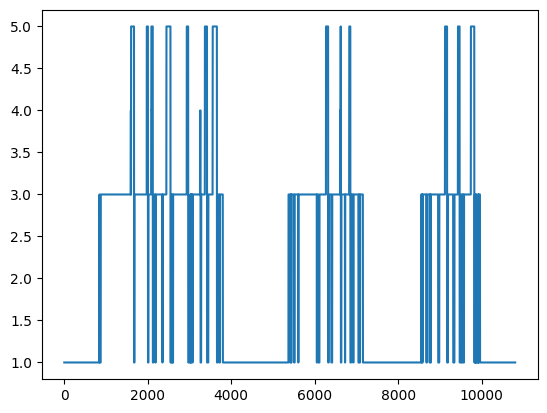

In [ ]:
plt.plot(sleep_scoring)

# Get NREM Epochs

In [ ]:
def get_first_NREM_epoch(arr, start):
  start_index = None
  for i in range(start, len(arr)):
    if arr[i] == 3:
      if start_index is None:
        start_index = i
    elif arr[i] != 3 and start_index is not None:
      return (start_index, i - 1, i)

  return (start_index, len(arr) - 1, len(arr)) if start_index is not None else None

def get_all_NREM_epochs(arr):
  nrem_epochs = []
  next_start = 0
  while next_start < len(arr)-1:
    indices = get_first_NREM_epoch(arr, next_start)
    if indices == None:
      break
    start, end, next_start = indices
    if end-start <= 30:
      continue
    nrem_epochs.append([start, end])
  return nrem_epochs

In [ ]:
nrem_epochs = np.array(get_all_NREM_epochs(sleep_scoring))
nrem_epochs

array([[ 873, 1592],
       [1681, 1974],
       [2016, 2080],
       [2133, 2179],
       [2192, 2347],
       [2356, 2445],
       [2606, 2932],
       [3075, 3251],
       [3279, 3366],
       [3450, 3552],
       [3667, 3710],
       [3728, 3796],
       [5370, 5412],
       [5440, 5501],
       [5518, 5602],
       [5609, 6047],
       [6112, 6267],
       [6333, 6394],
       [6417, 6604],
       [6637, 6721],
       [6728, 6823],
       [6870, 6916],
       [6928, 7044],
       [7084, 7151],
       [8583, 8671],
       [8684, 8747],
       [8781, 8954],
       [8982, 9117],
       [9190, 9314],
       [9345, 9427],
       [9574, 9737]])

# Epoch-wise

In [ ]:
fs = 1000 # Sampling rate/frequency
n_cycles = 3
nrem_data = []
nrem_filtered_data = []
for start, end in tqdm(nrem_epochs):
  pfc_data_part = pfc_data[start*fs:end*fs]
  delta_sig = filter_signal(pfc_data_part, fs, 'bandpass', (0.1, 6), n_cycles=n_cycles, filter_type='iir', butterworth_order=4, remove_edges=False)
  nrem_data.append(pfc_data_part)
  nrem_filtered_data.append(delta_sig)

100%|██████████| 35/35 [00:00<00:00, 66.37it/s]


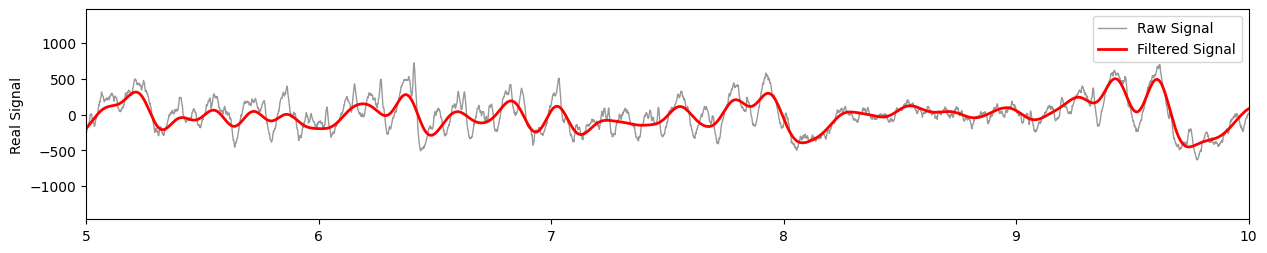

In [ ]:
# plotting
t = np.arange(len(nrem_data[0])) / fs
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,nrem_data[0], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data[0], 'r', label='Filtered Signal', lw=2)
plt.ylabel('Real Signal')
plt.legend()
plt.xlim((5,10));

In [ ]:
;for i in range(len(nrem_filtered_data)):
  IP, _, IA = emd.spectra.frequency_transform(nrem_filtered_data[i], 1000, 'nht')
  plt.figure(figsize=(15,6))
  plt.subplot(3,1,1)
  plt.plot(t,IP, 'k', label='Raw Signal', alpha=0.4, lw=1)
  plt.xlim((5,10));
  plt.subplot(3,1,2)
  plt.plot(t,IA, 'k', label='Raw Signal', alpha=0.4, lw=1)
  plt.xlim((5,10));
  plt.subplot(3,1,3)
  plt.plot(t,nrem_data[i], 'k', label='Raw Signal', alpha=0.4, lw=1)
  plt.plot(t,nrem_filtered_data[i], 'r', label='Filtered Signal', lw=2)
  plt.ylabel('Real Signal')
  plt.legend()
  plt.xlim((5,10));
  break

SyntaxError: cannot assign to literal (<ipython-input-20-abfc421b7b4d>, line 1)

In [ ]:
all_cycles = []
all_ctrl_points = []
for i in tqdm(range(len(nrem_filtered_data))):
  IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data[i], 1000, 'nht')
  C = emd.cycles.Cycles(IP)
  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('duration_samples', IA, func=len)

  amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
  lo_freq_duration = fs/0.1 # 10000 samples
  hi_freq_duration = fs/6 # 167 samples
  conditions = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'max_amp>{amp_thresh}']

  good_cycles = C.get_matching_cycles(conditions)
  cycles = []
  for j in range(C.ncycles):
    if good_cycles[j]:
      cycle = C.get_inds_of_cycle(j)
      cycles.append(nrem_filtered_data[i][cycle])

  ctrl_points = emd.cycles.get_control_points(nrem_filtered_data[i], C)
  ctrl_points = ctrl_points[good_cycles]

  all_cycles.append(cycles)
  all_ctrl_points.append(ctrl_points)

  0%|          | 0/35 [00:00<?, ?it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


  3%|▎         | 1/35 [00:15<09:03, 15.98s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


  6%|▌         | 2/35 [00:19<04:41,  8.54s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


  9%|▊         | 3/35 [00:19<02:31,  4.73s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


 11%|█▏        | 4/35 [00:19<01:30,  2.90s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


 14%|█▍        | 5/35 [00:21<01:16,  2.54s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


 17%|█▋        | 6/35 [00:22<01:02,  2.17s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


 20%|██        | 7/35 [00:29<01:40,  3.59s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


 26%|██▌       | 9/35 [00:30<00:54,  2.08s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


 29%|██▊       | 10/35 [00:30<00:40,  1.61s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


 31%|███▏      | 11/35 [00:31<00:30,  1.28s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


 34%|███▍      | 12/35 [00:31<00:21,  1.05it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 37%|███▋      | 13/35 [00:31<00:16,  1.36it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 40%|████      | 14/35 [00:31<00:11,  1.80it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 43%|████▎     | 15/35 [00:31<00:08,  2.24it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 46%|████▌     | 16/35 [00:31<00:07,  2.46it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 49%|████▊     | 17/35 [00:37<00:32,  1.80s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


 54%|█████▍    | 19/35 [00:37<00:18,  1.17s/it]

 Checking Cycles inputs - trimming singleton from input 'IP'


 57%|█████▋    | 20/35 [00:38<00:13,  1.09it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 60%|██████    | 21/35 [00:39<00:13,  1.04it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 63%|██████▎   | 22/35 [00:39<00:10,  1.24it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 66%|██████▌   | 23/35 [00:39<00:08,  1.39it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 69%|██████▊   | 24/35 [00:40<00:06,  1.78it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 71%|███████▏  | 25/35 [00:40<00:05,  1.71it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 74%|███████▍  | 26/35 [00:41<00:04,  2.03it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 77%|███████▋  | 27/35 [00:41<00:03,  2.08it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 80%|████████  | 28/35 [00:41<00:02,  2.36it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 83%|████████▎ | 29/35 [00:43<00:04,  1.44it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 86%|████████▌ | 30/35 [00:43<00:03,  1.41it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 89%|████████▊ | 31/35 [00:44<00:02,  1.55it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


 91%|█████████▏| 32/35 [00:44<00:01,  1.90it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


 97%|█████████▋| 34/35 [00:45<00:00,  2.12it/s]

 Checking Cycles inputs - trimming singleton from input 'IP'


100%|██████████| 35/35 [00:45<00:00,  1.30s/it]


<Figure size 640x480 with 0 Axes>

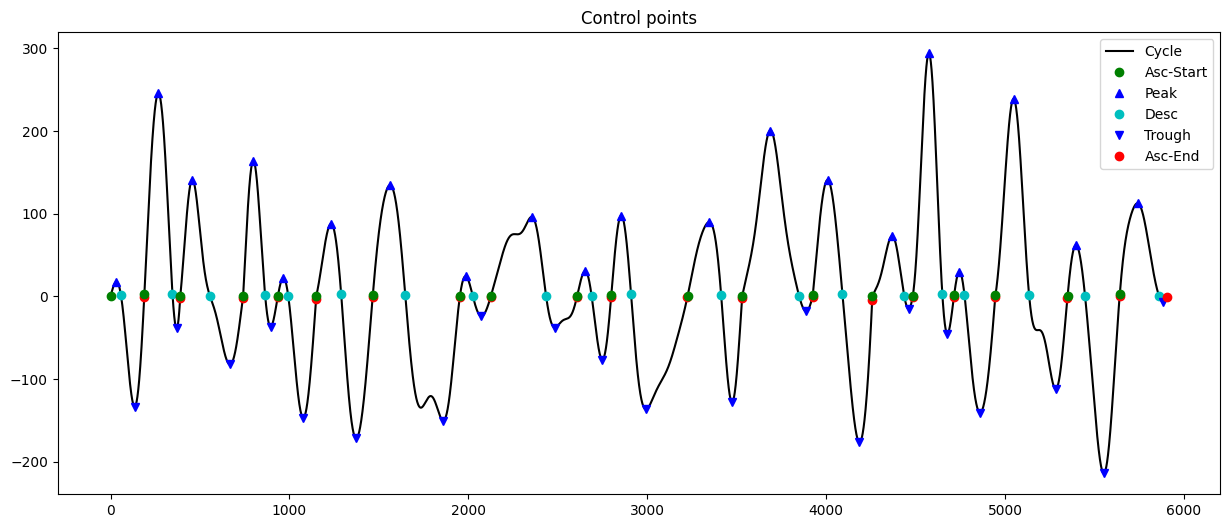

In [ ]:
# Define some marker styles and legend labels for the control points.
markers = ['og', '^b', 'oc', 'vb', 'or']
label = ['Asc-Start', 'Peak', 'Desc', 'Trough', 'Asc-End']

# Plot the first 10 cycles with control points
ncycles = 20
start = 0
epoch = 10
cycles = all_cycles[epoch]
ctrl_points = all_ctrl_points[epoch]

plt.figure()
plt.figure(figsize=(15,6))
plt.plot(111)
plt.title('Control points')
for ii in range(ncycles):
    # print('Cycle {0:2d} - {1}'.format(ii, ctrl_points[ii, :]+start))
    cycle = cycles[ii]
    plt.plot(np.arange(len(cycle))+start, cycle, 'k', label='Cycle')
    for jj in range(5):
        if np.isfinite(ctrl_points[ii, jj]):
            plt.plot(ctrl_points[ii, jj]+start, cycle[int(ctrl_points[ii, jj])], markers[jj], label=label[jj])
    start += len(cycle)

    # Only plot the legend for the first cycle
    if ii == 0:
        plt.legend()
# plt.ylim(-400, 400);

In [ ]:
all_ctrl_points_values = pd.DataFrame(columns=['epoch','peak','first_zero','trough','second_zero'])
for epoch in range(len(all_cycles)):
  ctrl_points = all_ctrl_points[epoch]
  cycles = all_cycles[epoch]

  ctrl_points_values = []
  start = 0
  for ii in range(len(ctrl_points)):
      cycle = cycles[ii]
      row = [epoch]
      for jj in range(1,5):
          if np.isfinite(ctrl_points[ii, jj]):
            row.append(cycle[int(ctrl_points[ii, jj])])
          else:
            row.append(None)
      ctrl_points_values.append(row)
      start += len(cycle)
  ctrl_points_values = pd.DataFrame(ctrl_points_values, columns=['epoch','peak','first_zero','trough','second_zero'])
  # print(ctrl_points_values)
  all_ctrl_points_values = pd.concat([all_ctrl_points_values, ctrl_points_values], ignore_index=True)

In [ ]:
all_ctrl_points_values

,epoch,peak,first_zero,trough,second_zero
0,0,287.607603,0.700345,-52.073222,-2.150579
1,0,44.427987,0.482221,-79.166408,-2.787704
2,0,221.776074,4.818150,-172.210862,-3.880729
3,0,56.839939,2.533916,-98.249084,-2.085320
4,0,225.024471,4.959793,-293.826058,-1.301347
...,...,...,...,...,...
6953,34,366.675815,0.349681,-294.240419,-3.818605
6954,34,348.954950,2.229364,-440.023082,-2.368176
6955,34,394.423594,5.682297,-355.518005,-2.825728
6956,34,275.258951,7.572317,-458.872740,-0.606820


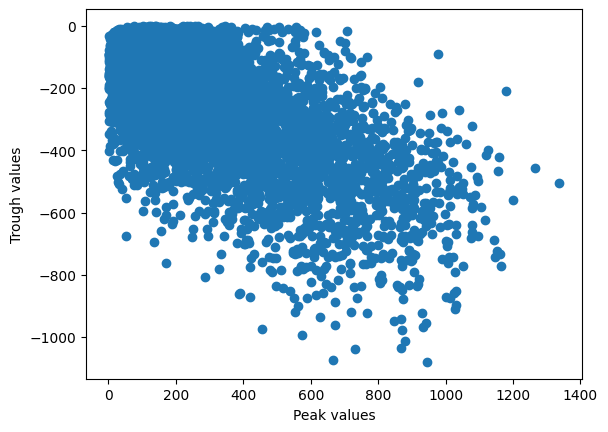

In [ ]:
plt.scatter(all_ctrl_points_values['peak'], all_ctrl_points_values['trough'])
plt.xlabel('Peak values')
plt.ylabel('Trough values');

# All epochs combined

In [ ]:
fs = 1000 # Sampling rate/frequency
nrem_data = []
for start, end in nrem_epochs:
  pfc_data_part = pfc_data[start*fs:end*fs]
  nrem_data.extend(pfc_data_part)
nrem_data = np.array(nrem_data)
# nrem_data = nrem_data[:fs*60*10]

In [ ]:
n_cycles = 3
nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=n_cycles, filter_type='iir', butterworth_order=6, remove_edges=False)

/usr/local/lib/python3.10/dist-packages/neurodsp/filt/utils.py:90: RuntimeWarning:

divide by zero encountered in log10



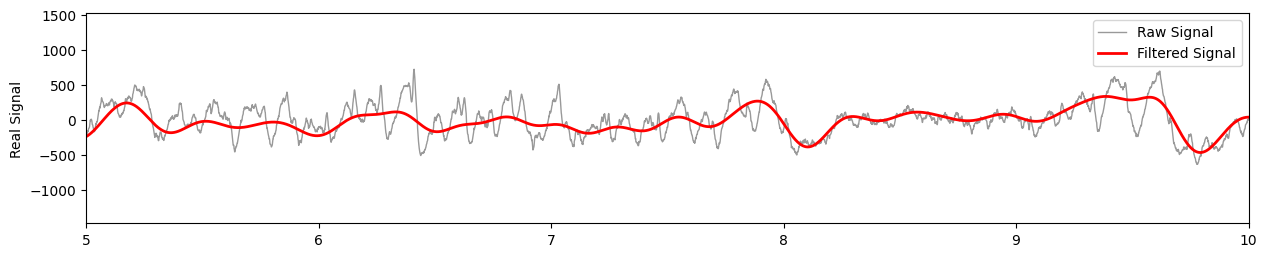

In [ ]:
# Plot NREM filtered data
t = np.arange(len(nrem_data)) / fs
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,nrem_data, 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data, 'r', label='Filtered Signal', lw=2)
plt.ylabel('Real Signal')
plt.legend()
plt.xlim((5,10));

In [ ]:
# Get cycles
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, 1000, 'nht')
C = emd.cycles.Cycles(IP)
C.compute_cycle_metric('max_amp', IA, func=np.max)
C.compute_cycle_metric('duration_samples', IA, func=len)
C.compute_cycle_metric('trough_values', nrem_filtered_data, func=np.min)
C.compute_cycle_metric('trough_position', nrem_filtered_data, func=np.argmin)

# C.compute_cycle_metric('peak', nrem_filtered_data, func=np.max)
# C.compute_cycle_metric('peak_position', nrem_filtered_data, func=np.argmax)
# C.compute_cycle_metric('peak_to_trough_position', nrem_filtered_data, func=lambda x: np.argmin(x)-np.argmax(x))

 Checking Cycles inputs - trimming singleton from input 'IP'


In [ ]:
def peak_before_trough(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
      return arr[i]
  return -1

def peak_before_trough_pos(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
      return i
  return -1

def peak_to_trough_duration(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 20, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
      return trough_pos-i
  return -1


C.compute_cycle_metric('peak_before_trough_val', nrem_filtered_data, func=peak_before_trough)
C.compute_cycle_metric('peak_before_trough_pos', nrem_filtered_data, func=peak_before_trough_pos)
C.compute_cycle_metric('peak_to_trough_duration', nrem_filtered_data, func=peak_to_trough_duration)

In [ ]:
metrics = C.get_metric_dataframe()
metrics

,is_good,max_amp,duration_samples,trough_values,trough_position,peak_before_trough_val,peak_before_trough_pos,peak_to_trough_duration
0,0,398.416333,28,-194.546944,0,-1.000000,-1,-1
1,0,973.388880,2694,-64.086909,2591,209.418664,2383,208
2,1,107.945613,315,-53.079504,254,98.357317,108,146
3,0,73.808702,613,-148.264482,243,59.601873,66,177
4,1,259.295631,309,-201.429410,227,108.295049,71,156
...,...,...,...,...,...,...,...,...
9431,1,291.069979,241,-122.895593,183,58.289516,54,129
9432,1,413.924107,472,-619.121028,322,390.620448,107,215
9433,1,365.899139,476,-350.993979,267,286.420523,81,186
9434,0,360.166049,502,-109.697913,272,301.978192,100,172


In [ ]:
amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
lo_freq_duration = fs/0.1 # 10000 samples / 10 sec
hi_freq_duration = fs/4 # 250 samples / .25 sec
conditions = ['is_good==1',
            f'duration_samples<{lo_freq_duration}',
            f'duration_samples>{hi_freq_duration}',
            f'peak_to_trough_duration<=500',
            f'peak_before_trough_val>0',
            # f'peak>{pos_thresh}',
            # f'trough<{neg_thresh},'
            f'max_amp>{amp_thresh}']

C.pick_cycle_subset(conditions)

In [ ]:
metrics = C.get_metric_dataframe(subset=True)
metrics

,index,is_good,max_amp,duration_samples,trough_values,trough_position,peak_before_trough_val,peak_before_trough_pos,peak_to_trough_duration,chain_ind
0,2,1,107.945613,315,-53.079504,254,98.357317,108,146,0
1,4,1,259.295631,309,-201.429410,227,108.295049,71,156,1
2,7,1,123.365278,623,-168.019042,385,115.031281,207,178,2
3,10,1,268.743088,498,-385.061739,353,268.741512,137,216,3
4,12,1,114.633800,391,-11.669787,353,111.961536,137,216,4
...,...,...,...,...,...,...,...,...,...,...
6022,9422,1,339.549011,409,-218.093062,266,277.858873,90,176,2190
6023,9423,1,997.752650,783,-282.780497,595,197.334035,381,214,2190
6024,9428,1,374.944543,354,-76.895386,280,366.440245,110,170,2191
6025,9432,1,413.924107,472,-619.121028,322,390.620448,107,215,2192


[-1 -1  0 -1  1 -1 -1  2 -1 -1  3 -1  4  5  6 -1  7  8  9 -1]


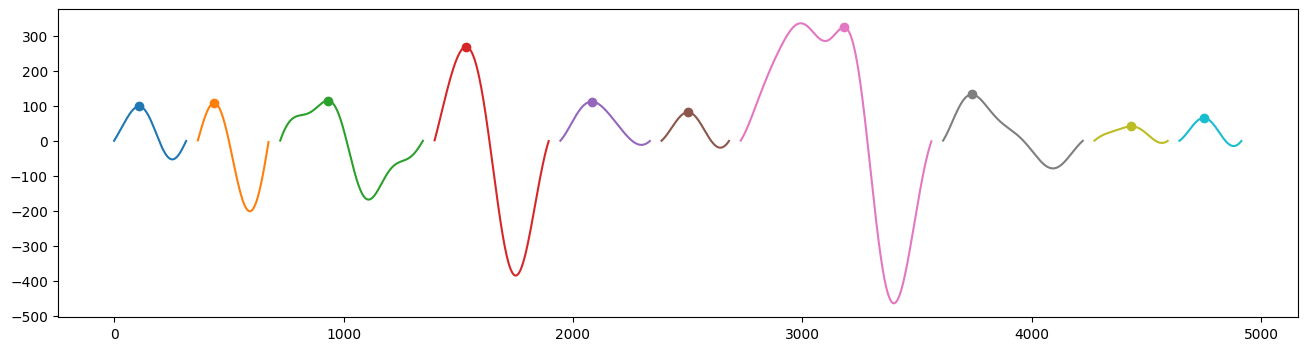

In [ ]:
cycles_to_plot = C.subset_vect[:20]
print(cycles_to_plot)
plt.figure(figsize=(16,4))
start = 0
for ii in range(len(cycles_to_plot)):
  if cycles_to_plot[ii]<0:
    continue
  inds = C.get_inds_of_cycle(ii)
  cycle = nrem_filtered_data[inds]
  row = metrics.iloc[cycles_to_plot[ii]]

  xinds = np.arange(len(inds)) + start
  plt.plot(xinds, cycle)
  plt.scatter(row['peak_before_trough_pos']+start, row['peak_before_trough_val'])

  start += len(inds)+50

In [ ]:
fig = px.density_contour(metrics, x="peak_before_trough_val", y="trough_values", marginal_x="histogram", marginal_y="histogram")
fig.show()

In [ ]:
fig = px.scatter_3d(metrics, x='peak_before_trough_val', y='trough_values', z='max_amp')
fig.show()

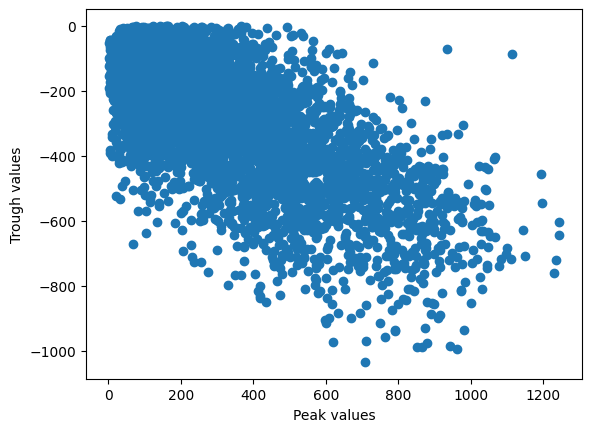

In [ ]:
plt.scatter(metrics['peak_before_trough_val'], metrics['trough_values'])
plt.xlabel('Peak values')
plt.ylabel('Trough values');

In [ ]:
good_cycles = C.get_matching_cycles(conditions)

In [ ]:
cycles = []
for i in tqdm(range(C.ncycles)):
    if good_cycles[i]:
      cycle = C.get_inds_of_cycle(i)
      cycles.append(nrem_filtered_data[cycle])

100%|██████████| 1307/1307 [00:02<00:00, 455.97it/s]


In [ ]:
ctrl_points = emd.cycles.get_control_points(nrem_filtered_data, C)
ctrl_points = ctrl_points[good_cycles]

In [ ]:
ctrl_points.shape

(863, 5)

<Figure size 640x480 with 0 Axes>

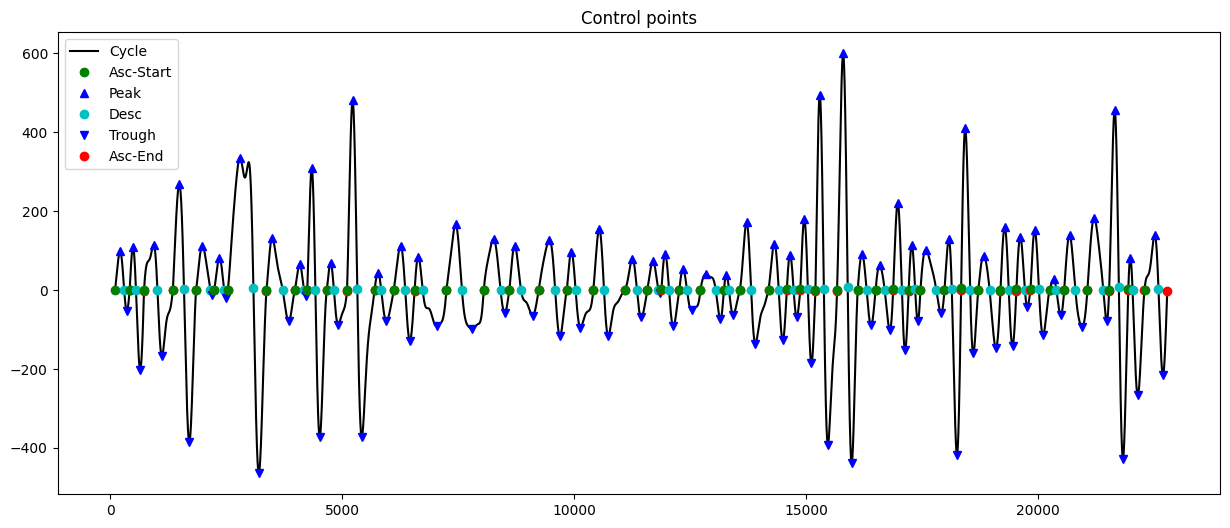

In [ ]:
# Define some marker styles and legend labels for the control points.
markers = ['og', '^b', 'oc', 'vb', 'or']
label = ['Asc-Start', 'Peak', 'Desc', 'Trough', 'Asc-End']

# Plot the first 10 cycles with control points
ncycles = 50
start = 100

plt.figure()
plt.figure(figsize=(15,6))
plt.plot(111)
plt.title('Control points')
for ii in range(ncycles):
    # print('Cycle {0:2d} - {1}'.format(ii, ctrl_points[ii, :]+start))
    cycle = cycles[ii]
    plt.plot(np.arange(len(cycle))+start, cycle, 'k', label='Cycle')
    for jj in range(5):
        if np.isfinite(ctrl_points[ii, jj]):
            plt.plot(ctrl_points[ii, jj]+start, cycle[int(ctrl_points[ii, jj])], markers[jj], label=label[jj])
    start += len(cycle)

    # Only plot the legend for the first cycle
    if ii == 0:
        plt.legend()
# plt.ylim(-400, 400);

In [ ]:
ctrl_points_values = pd.DataFrame(columns=['peak','first_zero','trough','second_zero'])
ctrl_points_values = []
start = 0
for ii in range(len(ctrl_points)):
    cycle = cycles[ii]
    row = []
    for jj in range(1,5):
        if np.isfinite(ctrl_points[ii, jj]):
          row.append(cycle[ctrl_points[ii, jj]])
        else:
          row.append(None)
    ctrl_points_values.append(row)
ctrl_points_values = pd.DataFrame(ctrl_points_values, columns=['peak','first_zero','trough','second_zero'])

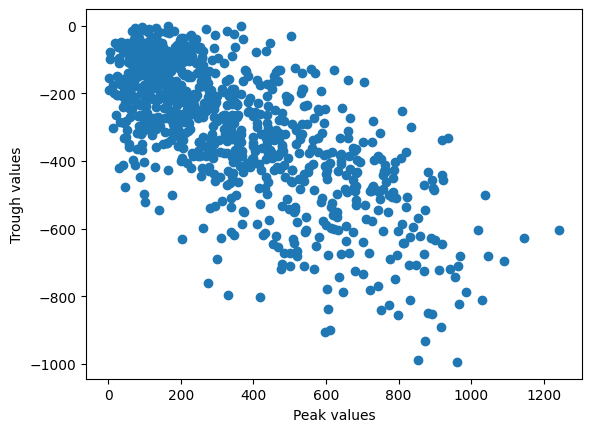

In [ ]:
plt.scatter(ctrl_points_values['peak'], ctrl_points_values['trough'])
plt.xlabel('Peak values')
plt.ylabel('Trough values');

In [ ]:
fig = px.density_contour(ctrl_points_values, x="peak", y="trough", marginal_x="histogram", marginal_y="histogram")
fig.show()